In [1]:
# try looking at dynamics from year to year

In [21]:
import time
import mysql.connector as mysql

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import Row, StructType, StructField, IntegerType, StringType

import os
import time
import random

#import igraph

import time
import numpy as np

import matplotlib.pyplot as plt
#import cairocffi as cairo

import seaborn as sns
import umap
import statsmodels.api as sm  # for kdemultivariate 

import json

#import matplotlib as mpl
#mpl.rcParams['pdf.fonttype'] = 42  # for vector graphics export
plt.rcParams['svg.fonttype'] = 'none'

In [ ]:
# get a big sample to train a pca reduction / umap reduction
#    todo ultimately probably want a better method here...var autoencoder?
#       graph embedding?


In [3]:
SUBMIT_ARGS = "--driver-class-path file:///home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar --jars file:///home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

db_name = 'test_pubmed'  # db name collisons? https://stackoverflow.com/questions/14011968/user-cant-access-a-database
url = "jdbc:mysql://localhost:3306/{}?useUnicode=true&useJDBCCompliantTimezoneShift=true&useLegacyDatetimeCode=false&serverTimezone=America/Chicago".format(db_name)  # mysql runs on port 3306
client_config = {'unix_socket':'/home/brendanchambers/.sql.sock',
                'database': db_name}  # for python connector

In [4]:
print('initializing spark')
# init spark
conf = SparkConf()
conf = (conf.setMaster('local[*]')
       .set('spark.driver.memory','100G')
       .set("spark.jars", "/home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar"))        
'''
.set('spark.executor.memory','1G')  # 20
.set('spark.driver.memory','1G')   # 40
.set('spark.driver.maxResultSize','500M')  #.set('spark.storage.memoryFraction',0))  # this setting is now a legacy option
.set('spark.python.worker.reuse', 'false')
.set('spark.python.worker.memory','512m')
.set('spark.executor.cores','1'))
'''
sc = SparkContext(conf=conf)
#sc.addJar('home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar')  # temp
spark = SparkSession(sc)  # don't need this for vanilla RDDs

print(sc._conf.getAll())

initializing spark
[('spark.repl.local.jars', 'file:///home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar'), ('spark.jars', '/home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar'), ('spark.driver.host', 'midway2-bigmem01.rcc.local'), ('spark.app.id', 'local-1567618262197'), ('spark.executor.id', 'driver'), ('spark.app.name', 'pyspark-shell'), ('spark.rdd.compress', 'True'), ('spark.driver.extraClassPath', 'file:///home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar'), ('spark.driver.port', '46524'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.submit.deployMode', 'client'), ('spark.ui.showConsoleProgress', 'true'), ('spark.driver.memory', '100G')]


# summarize temporal citation dynamics in aggregate

In [30]:
# todo figure: # publications, # citations, # unique citations

year_basepath = '/project2/jevans/brendan/pubmed_data_processing/year_pmids/'

tt = []
n_pubs = []
n_cite = []
n_unq_cite = []

start_year = 1958
end_year = 2018
for year in range(start_year, end_year+1):
    year_path = year_basepath + 'pubmed_state_' + str(year)
    
    with open(year_path, 'r') as f:
        year_state = json.load(f)
    
    tt.append(year)
    n_pubs.append(np.shape(year_state['publications'])[0])
    n_cite.append(np.shape(year_state['citations'])[0])
    
    unique_citations = np.unique(year_state['citations'])
    n_unq_cite.append(np.shape(unique_citations)[0])    
    

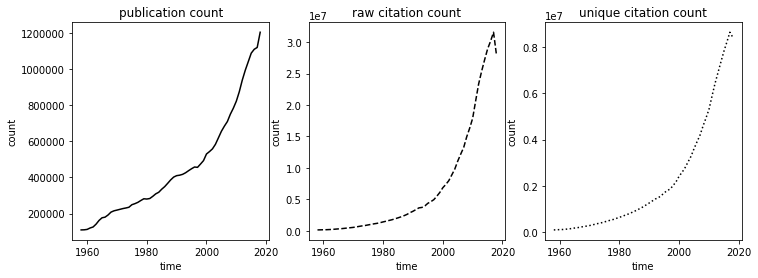

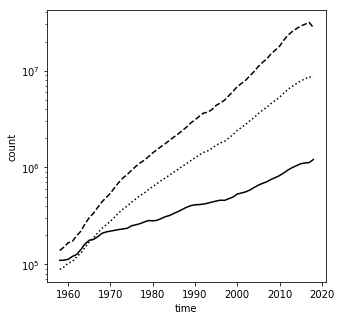

In [60]:
(f, ax) = plt.subplots(1, 3, sharex='all', figsize=(12,4))

ax[0].plot(tt, n_pubs, color='k')
ax[0].set_title('publication count')
ax[0].set_xlabel('time')
ax[0].set_ylabel('count')

ax[1].plot(tt, n_cite, color='k',linestyle='--')
ax[1].set_title('raw citation count')
ax[1].set_xlabel('time')
ax[1].set_ylabel('count')

ax[2].plot(tt, n_unq_cite, color='k',linestyle=':')
ax[2].set_title('unique citation count')
ax[2].set_xlabel('time')
ax[2].set_ylabel('count')

plt.savefig('dataset basic stats.png')
plt.savefig('dataset basic stats.svg')

## merged figure

(f, ax) = plt.subplots(1, 1, sharex='all', figsize=(5,5))

ax.semilogy(tt, n_pubs, color='k')
ax.set_xlabel('time')
ax.set_ylabel('count')

ax.semilogy(tt, n_cite, color='k',linestyle='--')

ax.semilogy(tt, n_unq_cite, color='k',linestyle=':')

plt.savefig('dataset basic merged stats.png')
plt.savefig('dataset basic merged stats.svg')

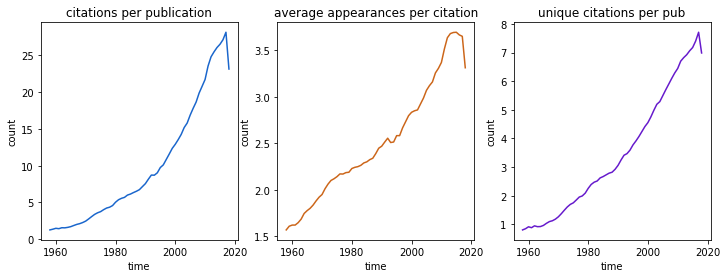

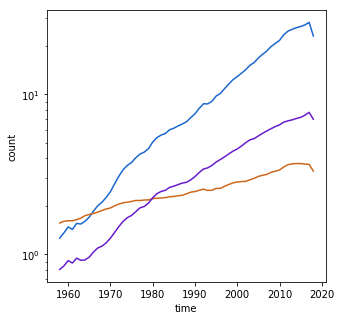

In [59]:
avg_citations = []
avg_unq_citations = []
rpt_ratio = []

for i, year in enumerate(range(start_year, end_year+1)):
    avg = 1.0*n_cite[i] / n_pubs[i]
    avg_citations.append(avg)
    
    avg_unq = 1.0*n_unq_cite[i] / n_pubs[i]
    avg_unq_citations.append(avg_unq)
    
    rpt = 1.0*n_cite[i] / n_unq_cite[i]
    rpt_ratio.append(rpt)

(f, ax) = plt.subplots(1, 3, sharex='all', figsize=(12,4))

ax[0].plot(tt, avg_citations, color=[0.1, 0.4, 0.8])
ax[0].set_title('citations per publication')
ax[0].set_xlabel('time')
ax[0].set_ylabel('count')

ax[1].plot(tt, rpt_ratio, color=[0.8, 0.4, 0.1])
ax[1].set_title('average appearances per citation')
ax[1].set_xlabel('time')
ax[1].set_ylabel('count')

ax[2].plot(tt, avg_unq_citations, color=[0.4, 0.1, 0.8])
ax[2].set_title('unique citations per pub')
ax[2].set_xlabel('time')
ax[2].set_ylabel('count')

plt.savefig('dataset ratio stats.png')
plt.savefig('dataset ratio stats.svg')


#### merged figure

(f, ax) = plt.subplots(1, 1, figsize=(5,5))

ax.semilogy(tt, avg_citations, color=[0.1, 0.4, 0.8])  # ax[0].set_title('citations per publication')
ax.semilogy(tt, rpt_ratio, color=[0.8, 0.4, 0.1])  #  ax[1].set_title('average appearances per citation')
ax.semilogy(tt, avg_unq_citations, color=[0.4, 0.1, 0.8])   # ax[2].set_title('unique citations per pub')
ax.set_xlabel('time')
ax.set_ylabel('count')

plt.savefig('dataset ratio merged stats.png')
plt.savefig('dataset ratio merged stats.svg')

### viz a single year

In [ ]:
year = 2004
year_basepath = '/project2/jevans/brendan/pubmed_data_processing/year_pmids/'
year_path = year_basepath + 'pubmed_state_' + str(year)
print(year_path)

with open(year_path, 'r') as f:
    year_state = json.load(f)
    
print(year_state.keys())
print(np.shape(year_state['publications']))  # ~400k , 600k, 1.2M (1990, 2004, 2018)
print(np.shape(year_state['citations']))     # 3M , 9.8M, 27.9M

unique_citations = np.unique(year_state['citations'])
print(np.shape(unique_citations))   # citation list includes duplicates (by design)

# old code for reference

In [5]:
# test one year

tablename_ = 'metadata'

sql = "(SELECT * FROM {}) AS t".format(tablename_)
print(sql)

start_time = time.time()
df_meta = spark.read.format('jdbc').option("url", url)\t
                              .option("dbtable", sql)\
                              .load().repartition(9).cache()
end_time = time.time()
print("dataframe loaded in {} s".format(end_time - start_time))

print(df_meta.rdd.getNumPartitions())

(SELECT * FROM metadata) AS t
dataframe loaded in 10.087861061096191 s
9


In [6]:
# for a single year

START_YEAR = 2008  # inclusive
END_YEAR = 2009  # exclusive
year_set = []
for year in range(START_YEAR, END_YEAR):
    year_set.append(str(year))
print(year_set)

start_time = time.time()

papers_for_year = df_meta.filter(df_meta.year.isin(year_set)).cache()

end_time = time.time()
print("elapsed: {}".format(end_time - start_time))


start_time = time.time()
N_papers = papers_for_year.count()
print("N papers: {}".format(N_papers))
end_time = time.time()
print("elapsed: {}".format(end_time - start_time))

start_time = time.time()
output = papers_for_year.collect()
for idx, row in enumerate(output):
    print(row)
    print()
    if idx > 15:
        break
end_time = time.time()
print("elapsed: {}".format(end_time - start_time))

['2008']
elapsed: 1.2285223007202148


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/brendanchambers/.conda/envs/embedding-base/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-d8c1f02ea5ac>", line 19, in <module>
    N_papers = papers_for_year.count()
  File "/software/spark-2.3.2-el7-x86_64/python/pyspark/sql/dataframe.py", line 455, in count
    return int(self._jdf.count())
  File "/home/brendanchambers/.conda/envs/embedding-base/lib/python3.7/site-packages/py4j/java_gateway.py", line 1255, in __call__
    answer = self.gateway_client.send_command(command)
  File "/home/brendanchambers/.conda/envs/embedding-base/lib/python3.7/site-packages/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/home/brendanchambers/.conda/envs/embedding-base/lib/python3.7/site-packages/py4j/java_gateway.py", line 1152, in send_command
    answer = smart_decode(self.strea

KeyboardInterrupt: 

In [ ]:
# try the same query with python mysql connector

# RESULTS this is slower than the pyspark dataframe method
#   suggesting that the indexed columns are being used smartly by pyspark
#   while also utilizing parallelization


year_ = 2008
sql = 'SELECT pmid, title, year FROM metadata WHERE year = {};'.format(year_)

db = mysql.connect(**client_config)
cursor = db.cursor()
start_time = time.time()
cursor.execute(sql)
print('elapsed time: {}'.format(time.time() - start_time))

start_time = time.time()
output = cursor.fetchall()
for idx,row in enumerate(output):
    print(row)
    print()
    if idx > 15:
        break
print('elapsed time: {}'.format(time.time() - start_time))


cursor.close()

In [ ]:
# get aggregate statistics for papers with abstracts--
#   which were actually embedded

# todo step through each year and read from the publication & citation csv

